In [3]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

df = pd.read_csv('datasets/shooting.csv')

print(len(df))
df.tail()

3116


Unnamed: 0   CrimeDate CrimeTime CrimeCode            Location  \
3111      566017  2016-12-31  17:58:00        9S       0 S HILTON ST   
3112      566257  2018-12-31  22:08:00        9S  2800 SPRINGHILL AV   
3113      566258  2018-12-31  22:08:00        9S     700 WHITMORE AV   
3114      566263  2018-12-31  22:10:00        9S   1200 E PRESTON ST   
3115      566264  2018-12-31  22:10:00        9S   1200 E PRESTON ST   

     Description Inside_Outside   Weapon   Post   District    Neighborhood  \
3111    SHOOTING        Outside  FIREARM  835.0  SOUTHWEST   SAINT JOSEPHS   
3112    SHOOTING        Outside  FIREARM  612.0  NORTHWEST     PARK CIRCLE   
3113    SHOOTING        Outside  FIREARM  721.0    WESTERN  EVERGREEN LAWN   
3114    SHOOTING        Outside  FIREARM  314.0    EASTERN          OLIVER   
3115    SHOOTING        Outside  FIREARM  314.0    EASTERN          OLIVER   

       Latitude  Longitude                               GeoLocation  \
3111  39.285422 -76.672448  (39.285422471524996,-76.672448261620346)   
3112  39.331266 -76.662881   (39.331266198075639,-76.66288100157351)   
3113  39.295557 -76.658166    (39.2955565493506,-76.658166447821344)   
3114  39.305131 -76.601749  (39.305130593546622,-76.601748899565564)   
3115  39.305131 -76.601749  (39.305130593546622,-76.601748899565564)   

          Premise  Total_Incidents  
3111  PARKING LOT                1  
3112       STREET                1  
3113  PUBLIC AREA                1  
3114  PUBLIC AREA                1  
3115  PUBLIC AREA                1

DBSCAN Clustering

In [4]:
location = df[['Latitude','Longitude']]

# Hapus data yang tidak memiliki koordinat
location = location.dropna()

# Hanya gunakan data yang berada di radius 39, -75 (Kota Baltimore) 
location = location.loc[(location['Latitude']>39) & (location['Longitude'] < -75)]  

In [5]:
print('=== Null ===')
print(location.isnull().sum())
print('=== Shape ===')
print(location.shape)

=== Null ===
Latitude     0
Longitude    0
dtype: int64
=== Shape ===
(3106, 2)


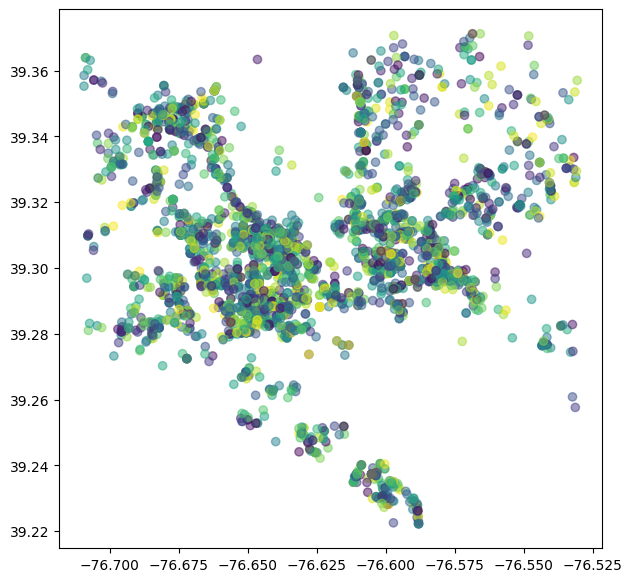

In [13]:
x = location['Longitude']
y = location['Latitude']

colors = np.random.rand(len(x))

plt.figure(figsize=(7,7))
plt.scatter(x, y,c=colors, alpha=0.5)
plt.show()

In [7]:
import folium
import re

m = folium.Map(location=[df.Latitude.median(), df.Longitude.median()], zoom_start=12.4, 
               tiles='OpenStreet Map')

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row.Latitude, row.Longitude],
        radius=5,
        popup=re.sub(r'[^a-zA-Z ]+', '', row.Location),
        color='#1787FE',
        fill=True,
        fill_colour='#1787FE'
    ).add_to(m)
    
m

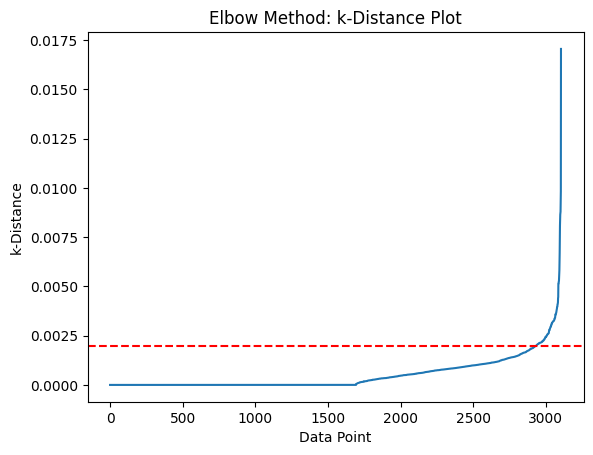

In [39]:
from sklearn.neighbors import NearestNeighbors

XD = location
XD = XD[~np.isnan(XD)]
XD = XD.dropna()

# K-Distance = 2x(Jumlah Dimensi)
nn = NearestNeighbors(n_neighbors=4)
nn = nn.fit(XD)
distances, indices = nn.kneighbors(XD)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

# Mengambil nilai epsilon dari elbow
epsilon = 0.0020
plt.axhline(y=epsilon, color='r', linestyle='--')
plt.xlabel('Data Point')
plt.ylabel('k-Distance')
plt.title('Elbow Method: k-Distance Plot')
plt.show()

In [36]:
from sklearn import metrics
from sklearn.cluster import DBSCAN

# min_samples=2.(no. of Dimensions)+1
db = DBSCAN(eps=0.0020, min_samples=5).fit(location)
labels = db.labels_

In [10]:
# import pickle

# with open('models/dbscan.pkl', 'wb') as file:
#     pickle.dump(db, file)

In [ ]:
import pickle
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.0020, min_samples=5).fit(X)
with open('models/dbscan.pkl', 'wb') as file:
    pickle.dump(db, file)

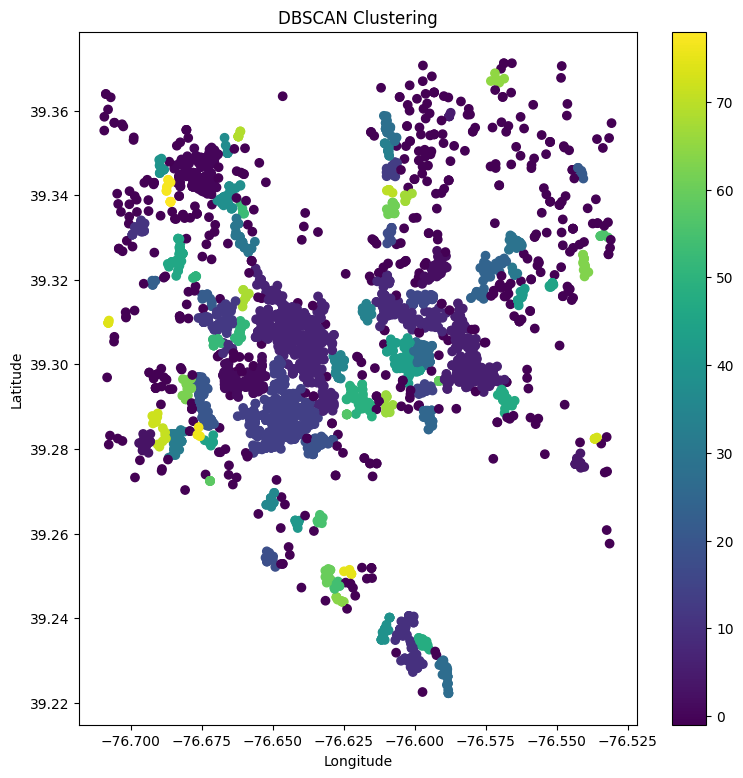

In [37]:
x = location['Longitude']
y = location['Latitude']

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
scatter = ax.scatter(x, y, c=labels)
ax.set_title('DBSCAN Clustering')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.colorbar(scatter)

In [38]:
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[labels >= 0] = True

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print('======')
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(location, labels))

Estimated number of clusters: 79
Estimated number of noise points: 518
Silhouette Coefficient: 0.115
